In [1]:
import pandas as pd
import numpy as np
import csv
import sqlite3
import re
import pickle
import itertools


from sklearn.dummy import DummyClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report


from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
plt.style.use('bmh')

In [3]:
pkl_filename= '/Users/xzhou/github/project_files/lending_club/loan3.pkl'

with open(pkl_filename, 'rb') as pklfile:
    df=pd.read_pickle(pkl_filename)

In [4]:
df.shape

(872926, 55)

In [5]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'payment_to_income_ratio_individual', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'term_ 36 months', 'term_ 60 months', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding',

In [6]:
# Noted loan_status is highly imbalanced. good vs. bad = 12 : 1

df.groupby('loan_status').count()

,loan_amnt,int_rate,installment,emp_length,annual_inc,payment_to_income_ratio_individual,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,inversed_mths_since_last_delinq,inversed_mths_since_last_record,inversed_mths_since_last_major_derog,income_to_debt_ratio,application_type_INDIVIDUAL,application_type_JOINT
loan_status,,,,,,,,,,,,,,,,,,,,,
bad,66325,66325,66325,66325,66325,66325,66325,66325,66325,66325,...,66325,66325,66325,66325,66325,66325,66325,66325,66325,66325
good,806601,806601,806601,806601,806601,806601,806601,806601,806601,806601,...,806601,806601,806601,806601,806601,806601,806601,806601,806601,806601


In [7]:
df.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,payment_to_income_ratio_individual,delinq_2yrs,earliest_cr_line,inq_last_6mths,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,inversed_mths_since_last_delinq,inversed_mths_since_last_record,inversed_mths_since_last_major_derog,income_to_debt_ratio,application_type_INDIVIDUAL,application_type_JOINT
0,5000.0,10.65,162.87,10.0,24000.0,good,27.65,0.0,31,1.0,...,0,0,0,0,0.000000,0.0,0.0,1.758499,1,0
1,2500.0,15.27,59.83,1.0,30000.0,bad,1.00,0.0,17,5.0,...,0,0,0,0,0.000000,0.0,0.0,17.783047,1,0
2,2400.0,15.96,84.33,10.0,12252.0,good,8.72,0.0,15,2.0,...,0,1,0,0,0.000000,0.0,0.0,4.144790,1,0
3,10000.0,13.49,339.31,10.0,49200.0,good,20.00,0.0,20,1.0,...,0,0,0,0,0.028571,0.0,0.0,8.788853,1,0
4,3000.0,12.69,67.79,1.0,80000.0,good,17.94,0.0,20,0.0,...,0,0,0,0,0.026316,0.0,0.0,2.879459,1,0


In [8]:
# Assign bad loan as value 1 and good loan as value 0

df['loan_status'] = (df['loan_status']=='bad').astype(int)

In [9]:
df.describe(include = 'all')

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,payment_to_income_ratio_individual,delinq_2yrs,earliest_cr_line,inq_last_6mths,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,inversed_mths_since_last_delinq,inversed_mths_since_last_record,inversed_mths_since_last_major_derog,income_to_debt_ratio,application_type_INDIVIDUAL,application_type_JOINT
count,872926.000000,872926.000000,872926.000000,872926.000000,8.729260e+05,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,...,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000
mean,14779.352803,13.252395,437.392570,6.101334,7.500838e+04,0.075980,18.182628,0.314092,18.306563,0.684289,...,0.000635,0.011380,0.005272,0.002560,0.031165,0.003001,0.009687,24.496675,0.999488,0.000512
std,8427.927252,4.384235,243.959234,3.444948,6.469140e+04,0.264966,17.290395,0.861302,7.432795,0.966162,...,0.025184,0.106069,0.072416,0.050535,0.081515,0.014310,0.037072,742.312695,0.022623,0.022623
min,500.000000,5.320000,16.080000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,9.990000,261.880000,3.000000,4.500000e+04,0.000000,11.940000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.186915,1.000000,0.000000
50%,13000.000000,12.990000,382.810000,6.098617,6.500000e+04,0.000000,17.680000,0.000000,17.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.136547,1.000000,0.000000
75%,20000.000000,16.200000,573.060000,10.000000,9.000000e+04,0.000000,23.960000,0.000000,22.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.007092,9.139470,1.000000,0.000000
max,35000.000000,28.990000,1445.460000,10.000000,9.500000e+06,1.000000,9999.000000,39.000000,72.000000,8.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,225000.000000,1.000000,1.000000


In [10]:
y=df['loan_status']
X=df.drop('loan_status', axis=1)

In [11]:
# Undersampling will be applied to X_train. Even a test_size of 0.1 will give me a test_size of 87K

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1, random_state=99)

In [12]:
ssX=StandardScaler()
X_train_scaled=ssX.fit_transform(X_train)
X_test_scaled=ssX.transform(X_test)

In [13]:
runs=RandomUnderSampler()
X_train_scaled_under, y_train_under=runs.fit_sample(X_train_scaled, y_train)

In [14]:
X_train_scaled_under.shape

(119390, 54)

In [15]:
y_train_under.shape

(119390,)

In [17]:
models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None), 
          BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100, n_jobs=-1),
          SVC(probability=True), LogisticRegression(C=0.1), SGDClassifier(loss='log', random_state=42, alpha=0.01)]
model_names = ["Random Forest", "Decision Tree",'Bagging Classifier','SVC','Logistic','SGD-Log']

In [18]:
model_pkl_filename= '/Users/xzhou/github/project_files/lending_club/loan_model1.pkl'

In [19]:
# Open the pickle file that stores details for model comparison
# If not existed, create pickle file by runing through various models

roc_plotting=[]

try: 
    with open (model_pkl_filename, 'rb') as pklfile2:
        roc_plotting = pickle.load(pklfile2)    

except: 
    for clf, name in zip(models, model_names):
        clf.fit(X_train_scaled_under, y_train_under)
        y_pred = clf.predict_proba(X_test_scaled)
        fpr, tpr, _ = roc_curve (y_test, y_pred[:, 1])
        auc_score = auc(fpr, tpr)
        roc_plotting.append((name, tpr, fpr, auc_score))
        
        # Store in pickle file if file is not existed
        with open (model_pkl_filename, 'wb') as pklfile2:
            pickle.dump(roc_plotting, pklfile2)

Text(0.5,1,'ROC Curves')

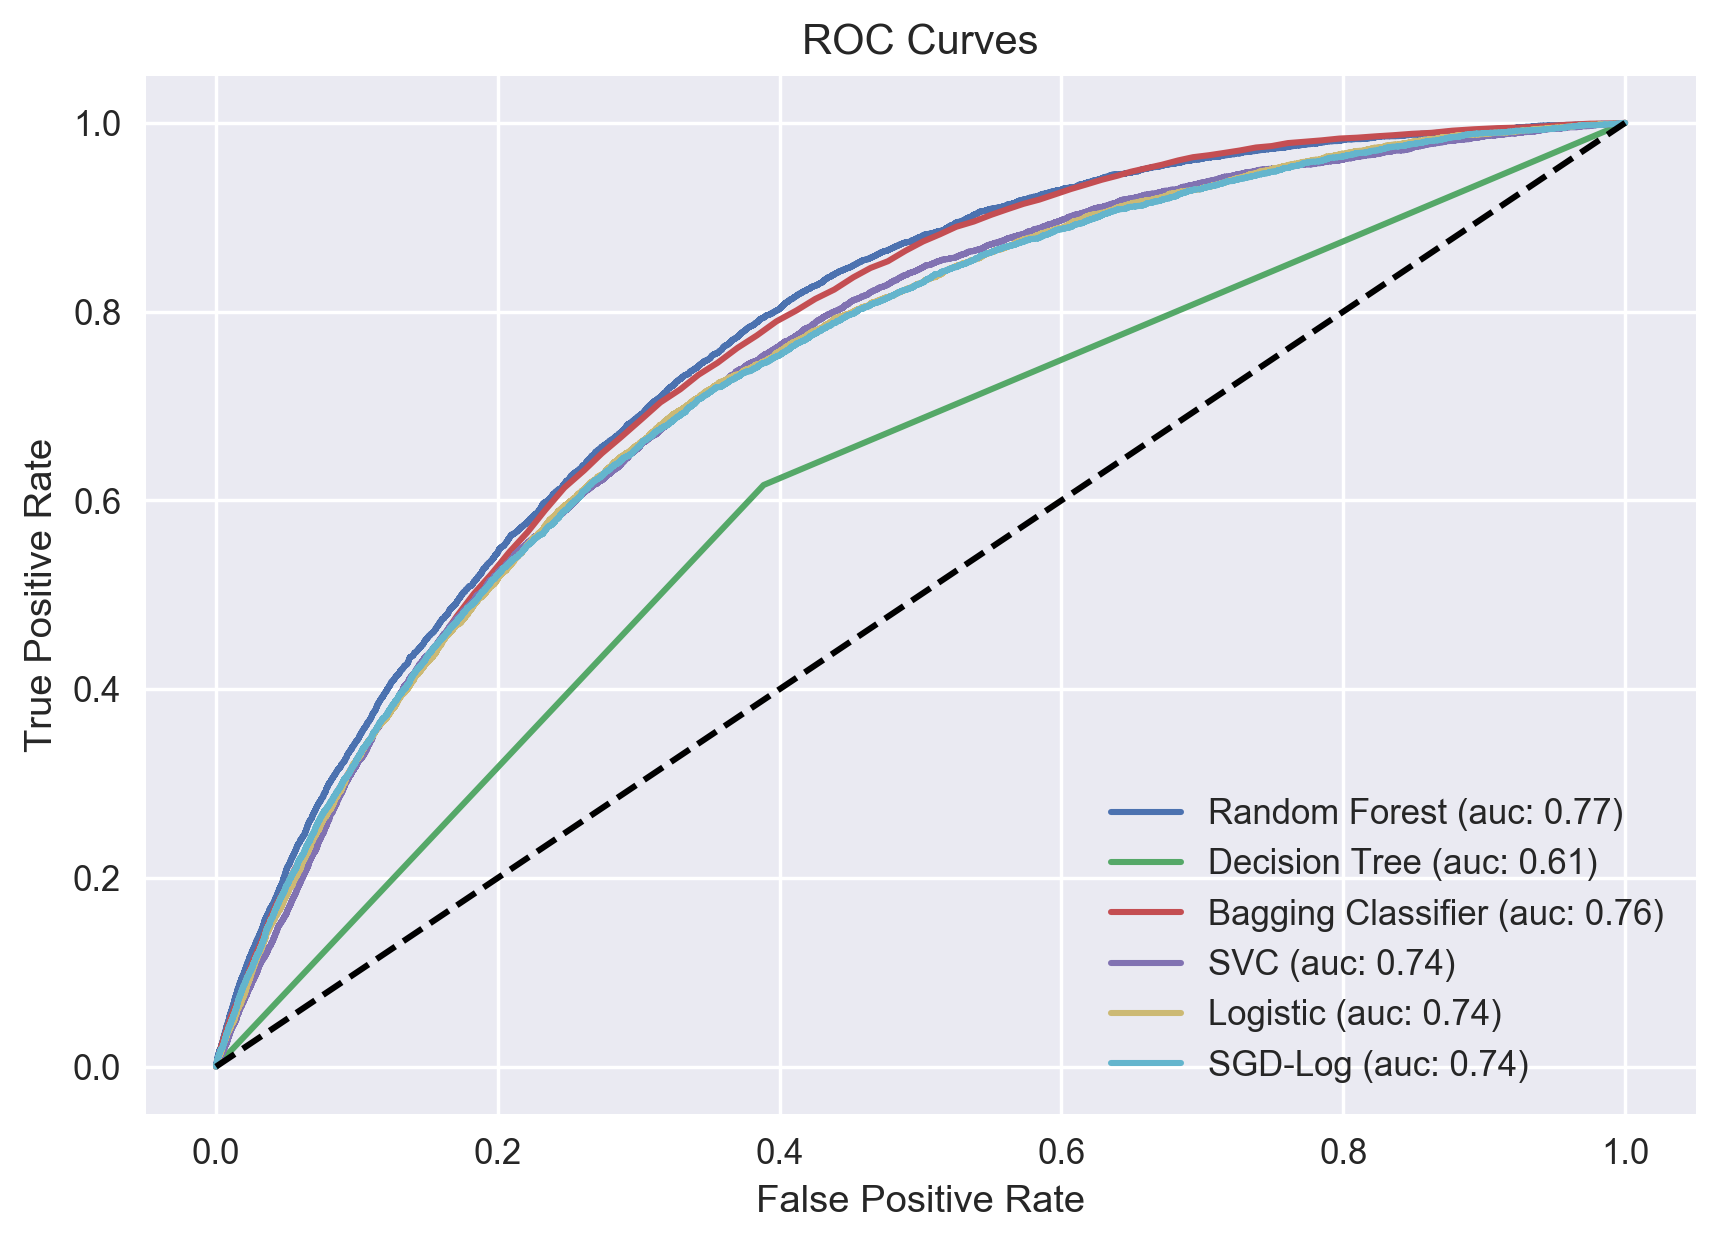

In [20]:
# Plot ROC curve for model comparison
# Noted Ramdom Forecast produces best result with an AUC of 0.77

plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.plot([0,1], [0,1], color='k', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc='lower right')
plt.title('ROC Curves')

In [21]:
param_grid = {
    'n_estimators': [100, 300],
    'max_features': ['auto', 'log2'], # auto == sqrt
    'max_depth': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}

In [22]:
rfc = RandomForestClassifier(random_state=99)

In [23]:
rf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=4, verbose=2, n_jobs=-1)
rf.fit(X_train_scaled_under, y_train_under)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=100 
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=100 
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=100 
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=100, total=  27.1s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=100, total=  27.2s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=100, total=  27.4s
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=100, total=  27.1s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV]  criterion

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.2min


[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=100, total=  47.4s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=300 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=100, total=  47.5s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=300 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=100, total=  47.4s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=300 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=300, total= 2.3min
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=300, total= 2.3min
[CV] criterion=gini, max_depth=20, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=300, total= 2.3min
[CV] criterion=gini, max_depth=20, max_features=log2, n_estimators=100 
[CV] criterion=gini, max_depth=20, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=20, max_featur

[CV] criterion=entropy, max_depth=20, max_features=auto, n_estimators=300 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=300, total= 2.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=300, total= 2.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=300, total= 2.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=300, total= 2.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=100, total=  42.5s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=300 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=100, total=  43.0s
[CV] crite

[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 32.7min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 300], 'max_features': ['auto', 'log2'], 'max_depth': [10, 15, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [25]:
rf.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 300}

In [26]:
rf_best = RandomForestClassifier(max_depth=15, max_features='auto', n_estimators=300, random_state=99)

In [28]:
rf_best.fit(X_train_scaled_under, y_train_under)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False)

In [29]:
y_predict=rf.predict(X_test_scaled)

In [30]:
accuracy_score(y_test, y_predict)

0.6529389527224405

In [ ]:
model_params_filename= '/Users/xzhou/github/project_files/lending_club/loan_params.pkl'

try: 
    with open(model_params_filename, 'rb') as pklfile:
        model_params=pickle.load(pklfile)
except:
    with open(model_params_filename, 'wb') as pklfile:
        pickle.dump(rf.best_params, pklfile)

In [16]:
param_grid = {
    'n_estimators': [300, 500],
    'max_features': ['auto', 'log2'], # auto == sqrt
    'max_depth': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}

In [17]:
rfc = RandomForestClassifier(random_state=99)

In [18]:
rf2 = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=4, verbose=2, n_jobs=-1)
rf2.fit(X_train_scaled_under, y_train_under)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=300, total= 1.5min
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=300, total= 1.5min
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=300, total= 1.5min
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=300, total= 1.6min
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=500 
[CV]  criterion

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 23.0min


[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=300, total= 2.4min
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=300, total= 2.4min
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=300, total= 2.4min
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=500, total= 3.9min
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=500, total= 3.9min
[CV] criterion=gini, max_depth=20, max_features=log2, n_estimators=300 
[CV] criterion=gini, max_depth=20, max_features=log2, n_estimators=300 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=500, total= 3.9min
[CV] criterion=gini, max_depth=20, max_features=log2, n_estimators=300 
[CV]  criterion=gini, max_depth=20, max_featur

[CV] criterion=entropy, max_depth=20, max_features=auto, n_estimators=500 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=500, total= 4.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=300 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=500, total= 4.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=300 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=500, total= 4.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=300 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=500, total= 4.5min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=300 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=300, total= 2.8min
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=300, total= 2.8min
[CV] crite

[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 70.4min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 500], 'max_features': ['auto', 'log2'], 'max_depth': [10, 15, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [22]:
rf2.best_score_

0.6735823770835079

In [23]:
rf2.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 500}

In [24]:
model2_filename= '/Users/xzhou/github/project_files/lending_club/loan_model2.pkl'

try: 
    with open(model2_filename, 'rb') as pklfile:
        model=pickle.load(pklfile)
except:
    with open(model2_filename, 'wb') as pklfile:
        pickle.dump(rf2, pklfile)

In [25]:
rf2

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 500], 'max_features': ['auto', 'log2'], 'max_depth': [10, 15, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [26]:
with open(model2_filename, 'rb') as pklfile:
        model2=pickle.load(pklfile)

In [27]:
model2

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 500], 'max_features': ['auto', 'log2'], 'max_depth': [10, 15, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [30]:
y_predict2 = rf2.predict_proba(X_test_scaled)

In [29]:
accuracy_score(y_test, y_predict2)

0.6360074690983241

In [33]:
roc_plotting2=[]
fpr1, tpr1, _ = roc_curve (y_test, y_predict2[:, 1])
auc_score1 = auc(fpr1, tpr1)
roc_plotting2.append(( tpr1, fpr1, auc_score1))

Text(0.5,1,'ROC Curves')

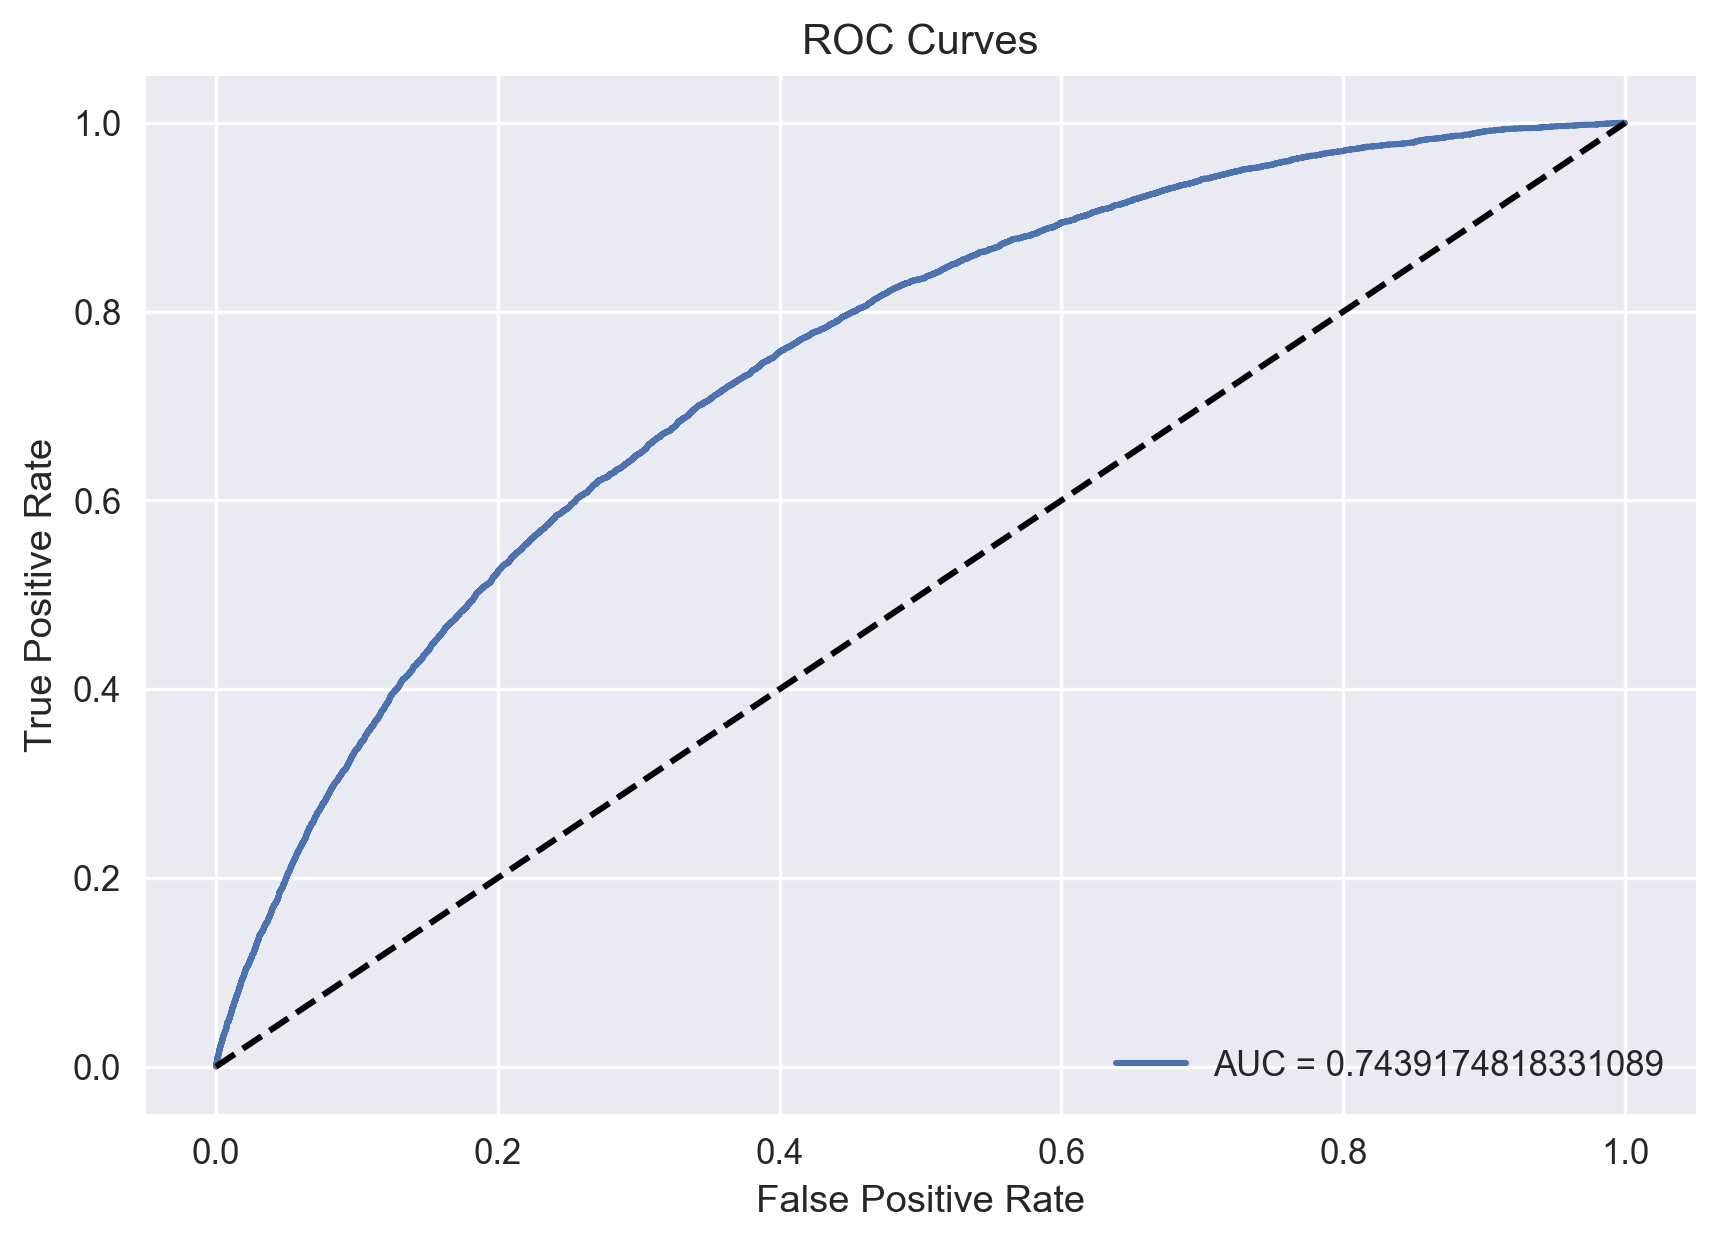

In [46]:
# Plot ROC curve for model comparison
# Noted Ramdom Forecast produces best result with an AUC of 0.77

plt.figure(dpi=250)
for tpr1, fpr1, auc_score1 in roc_plotting2:
    plt.plot(fpr1, tpr1, label='AUC = '+str(auc_score1))
plt.plot([0,1], [0,1], color='k', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc='lower right')
plt.title('ROC Curves')

In [59]:
y_predict_hard = rf2.predict (X_test_scaled)


array([0, 0, 0, ..., 0, 0, 0])

In [62]:
y_predict_hard.astype(int)
y_test.astype(int)

304381    0
338533    0
337666    0
300811    0
25640     0
677012    0
86724     0
417079    0
125014    1
413819    0
842920    1
333265    0
827674    1
488376    0
150526    1
17540     0
279636    0
740674    0
160538    0
164057    0
378531    0
346830    0
300173    0
561313    0
540596    0
287042    1
856123    0
414877    0
623897    0
574585    0
         ..
202938    1
67241     0
642659    0
603198    0
694017    0
692082    0
409473    0
393625    0
371826    0
573760    0
408433    0
751191    0
631746    1
201899    0
790189    0
420785    0
183558    0
390785    0
879798    0
630918    0
717855    0
690224    1
190317    1
369057    0
74698     0
356861    0
693670    0
307137    0
671856    0
160490    1
Name: loan_status, Length: 87293, dtype: int64

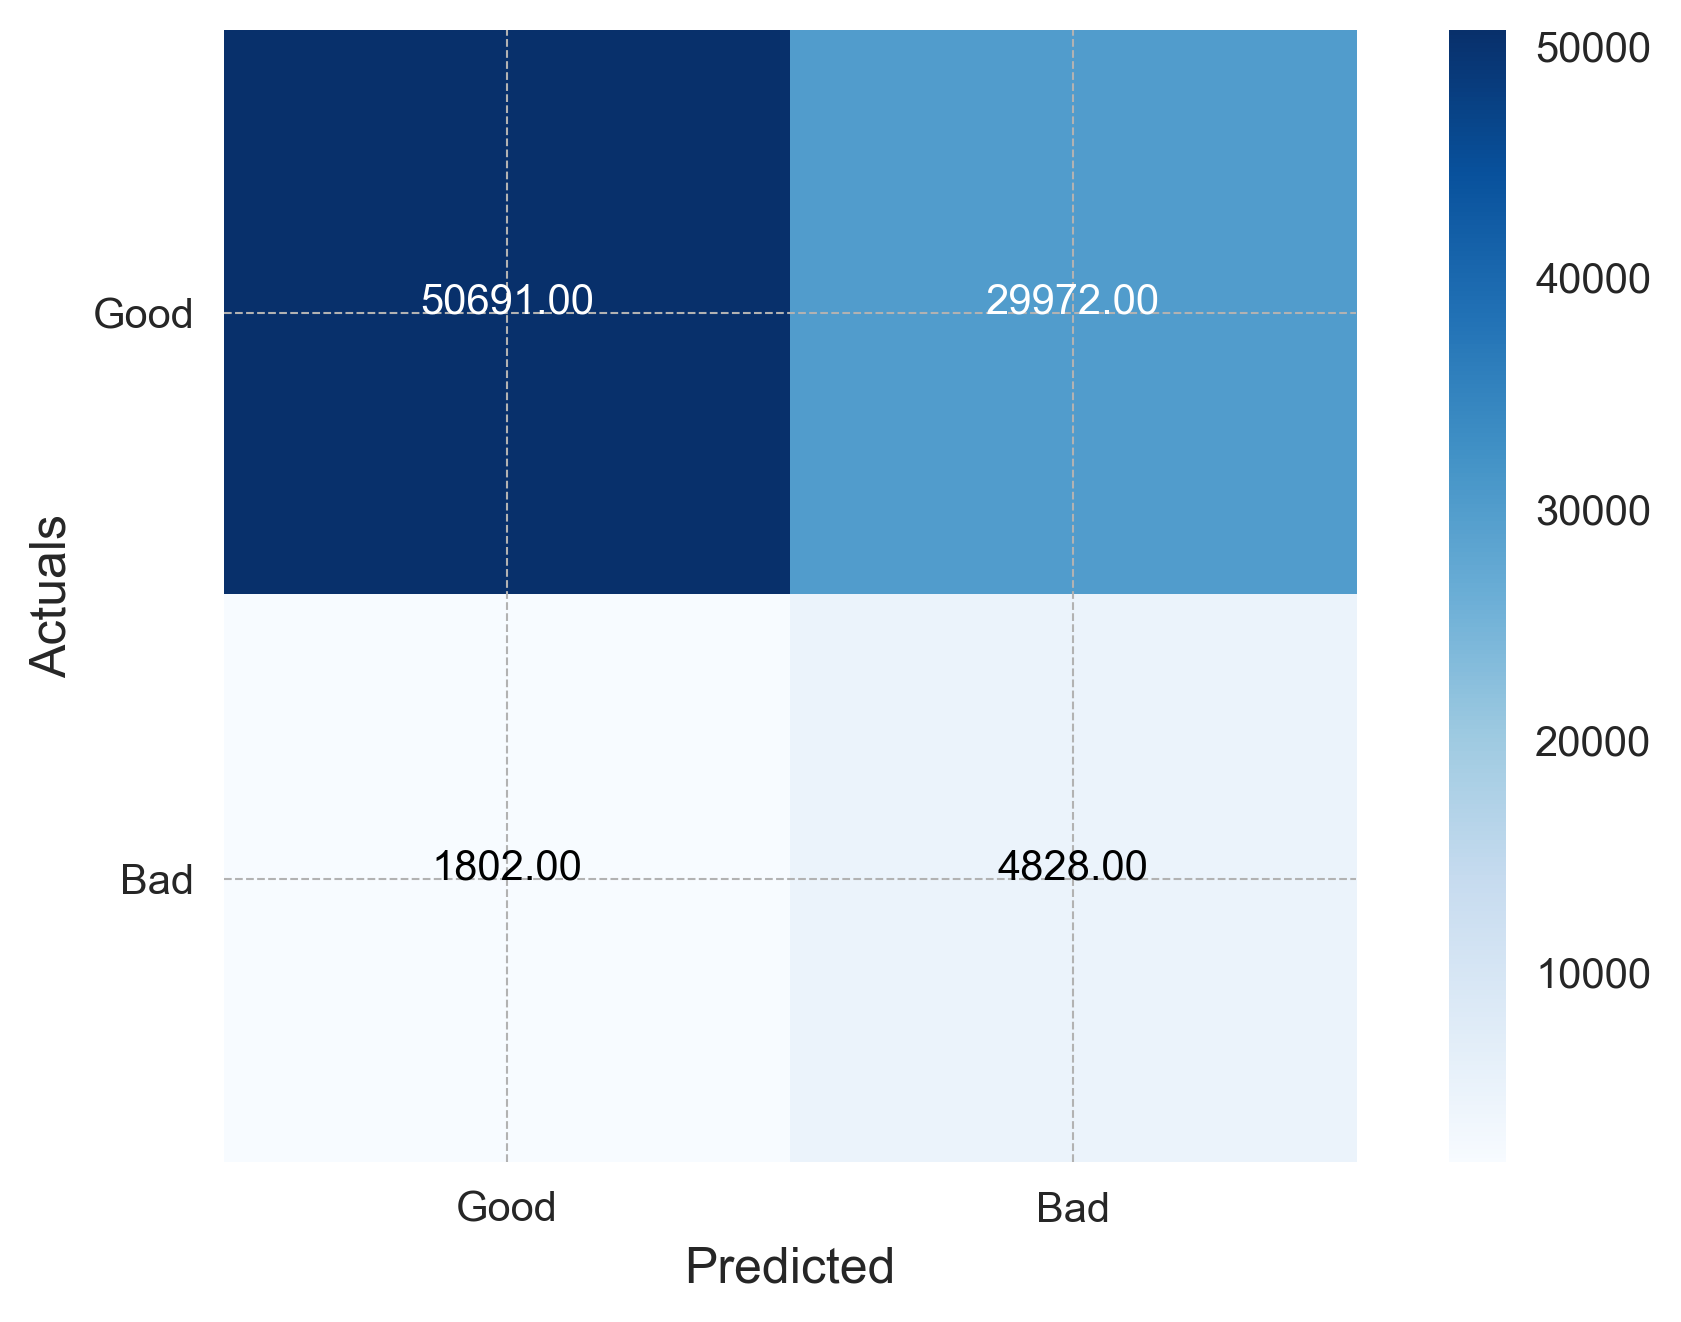

In [69]:

plt.figure(figsize=[8,5], dpi=300)
cm = confusion_matrix (y_test, y_predict_hard)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0,1], ['Good', 'Bad'])
plt.yticks([0,1], ['Good', 'Bad'])
plt.ylabel('Actuals')
plt.xlabel('Predicted')

fmt = '.2f'
thresh = cm.max() / 2

for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment='center',
             color='white' if cm [i, j] > thresh else 'black')

In [66]:
cm.shape

(2, 2)

In [67]:
cm

array([[50691, 29972],
       [ 1802,  4828]])